In [1]:
#import required libraries
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import pyplot
from rasterio.plot import show
import pyproj
%matplotlib inline
import os
import cv2 as cv

In [27]:
def read_and_display_image(image_path):
    """
    Read a multiband image using rasterio, convert it to a 3-channel (RGB) NumPy array, and display it.
    """
    with rasterio.open(image_path) as dataset:
        # Read all bands into a single NumPy array (assuming RGB order)
        image = dataset.read([1, 2, 3])  # Band indices may vary based on the image
        
        # Move the channel dimension to the last position, as expected by matplotlib
        image_rgb = np.moveaxis(image, 0, -1)
        
        # If the image has a larger dtype (like uint16), convert it to uint8
        if image_rgb.dtype != np.uint8:
            scale_factor = 255.0 / image_rgb.max()
            image_rgb = (image_rgb * scale_factor).astype(np.uint8)
        
        plt.imshow(image_rgb)
        plt.title('Original Image')
        plt.show()
        return image_rgb

In [37]:
# def define_color_ranges():
#     """
#     Define BGR color ranges for various features.
#     """
#     # Green color range for identifying vegetation
#     green_bgr = np.array([0, 120, 0])
#     green_upper = green_bgr + 75
#     green_lower = green_bgr - 75

#     return green_lower, green_upper

In [55]:
def define_color_ranges():
    """
    Define RGB color ranges for urban green areas.
    """
    
    green_rgb = np.array([0, 120, 0]) 
    green_upper = green_rgb + np.array([60, 135, 60])  
    green_lower = green_rgb - np.array([60, 100, 60])  
    
    # Clip the values to valid color ranges
    green_upper = np.clip(green_upper, 0, 255)
    green_lower = np.clip(green_lower, 0, 255)

    return green_lower, green_upper

In [56]:
def create_mask(image, lower, upper):
    """
    Create a mask for the specified color range.
    The image is already in RGB format, so we can directly apply the mask.
    """
    # Create the mask
    mask = cv.inRange(image, lower, upper)
    plt.imshow(mask, cmap='gray')
    plt.title('Green Area Mask')
    plt.show()
    return mask

In [57]:
def find_and_show_contours(mask, image):
    """
    Find contours in the mask and draw them on the image.
    """
    contours, _ = cv.findContours(mask.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    print(f"Found {len(contours)} green areas.")
    cv.drawContours(image, contours, -1, (0, 255, 0), 2)
    plt.imshow(image)
    plt.title('Contours of Green Areas')
    plt.show()
    return contours

In [58]:
image_path = 'dop40_clip.TIF'

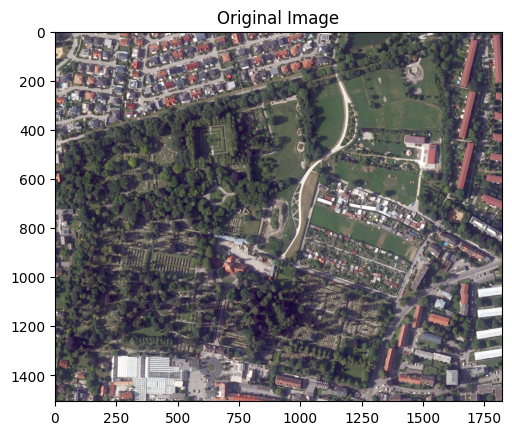

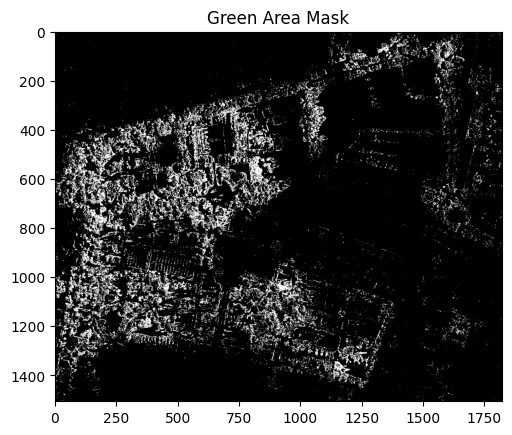

Found 13152 green areas.


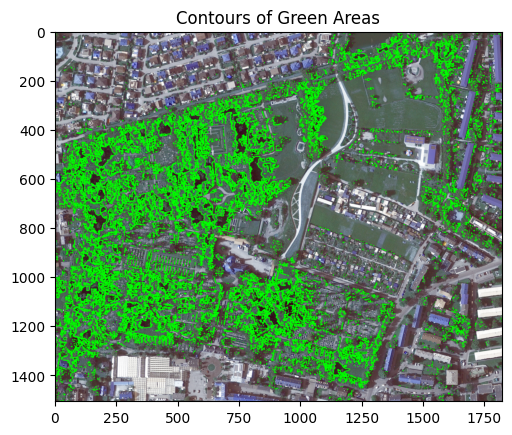

In [59]:
image = read_and_display_image(image_path)
green_lower, green_upper = define_color_ranges()
mask = create_mask(image, green_lower, green_upper)
image_contours = read_image('dop40_clip.TIF')
contours = find_and_show_contours(mask, image_contours)

## Gras

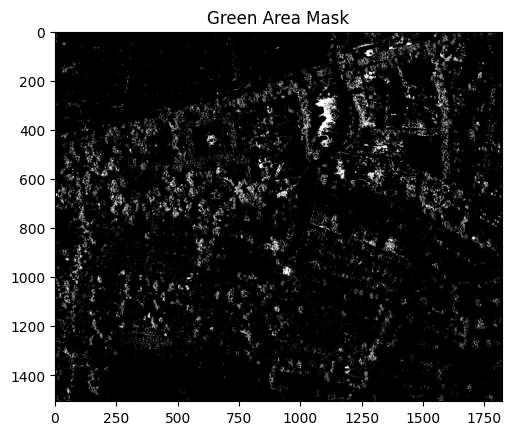

Found 22458 green areas.


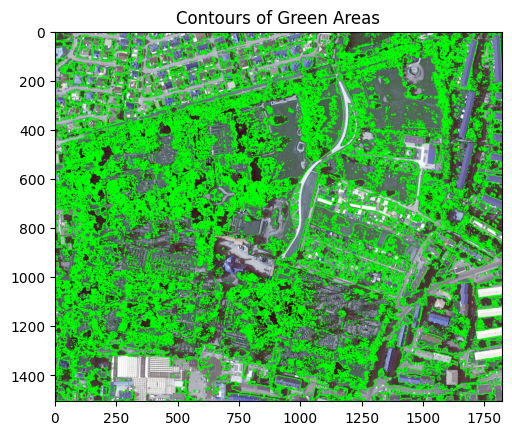

In [64]:
def define_grass_color_ranges():
    """
    Define RGB color ranges for grass in urban areas.
    Grass typically has a lighter and more yellow-green hue compared to trees.
    """
   
    grass_rgb = np.array([40, 160, 45]) 
    grass_upper = grass_rgb + np.array([40, 95, 40])  
    grass_lower = grass_rgb - np.array([40, 80, 40]) 

    # Clip the values to valid color ranges
    grass_upper = np.clip(grass_upper, 0, 255)
    grass_lower = np.clip(grass_lower, 0, 255)

    return grass_lower, grass_upper

grass_lower, grass_upper = define_grass_color_ranges()
grass_mask = create_mask(image, grass_lower, grass_upper)
grass_contours = find_and_show_contours(grass_mask, image_contours)

## More fine-tuning

In [65]:
def apply_morphological_operations(mask, kernel_size=5):
    """
    Apply morphological operations to clean up the mask.
    """
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (kernel_size, kernel_size))
    cleaned_mask = cv.morphologyEx(mask, cv.MORPH_CLOSE, kernel)
    cleaned_mask = cv.morphologyEx(cleaned_mask, cv.MORPH_OPEN, kernel)
    return cleaned_mask

In [66]:
def filter_contours(contours, min_area=100, max_area=5000):
    """
    Filter contours by area.
    """
    filtered_contours = [cnt for cnt in contours if min_area < cv.contourArea(cnt) < max_area]
    print(f"Filtered to {len(filtered_contours)} contours after applying area filter.")
    return filtered_contours

In [67]:
kernel_size = 5  # Adjust this based on the level of noise
min_area = 100   # Minimum area to be considered as grass
max_area = 5000  # Maximum area to be considered as grass

Found 1125 shapes
Filtered to 325 contours after applying area filter.


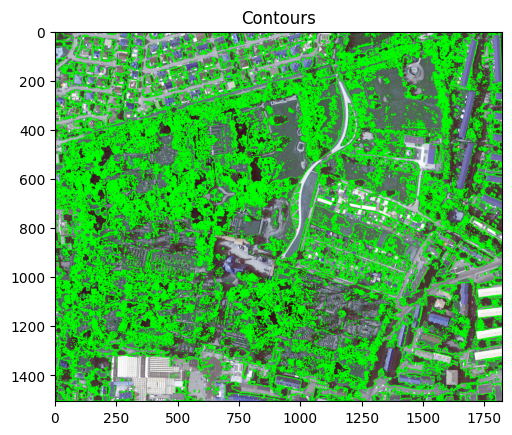

In [68]:
cleaned_mask = apply_morphological_operations(grass_mask, kernel_size)
contours = find_contours(cleaned_mask)  
filtered_contours = filter_contours(contours, min_area, max_area)
show_contours(filtered_contours, image_contours)

## Inlcuding object-based approach

In [72]:
from skimage.segmentation import slic
from skimage.measure import regionprops
from skimage.color import rgb2lab

In [73]:
def segment_image(image):
    """
    Segment the image into superpixels.
    """
    # Convert the image to Lab color space for better segmentation
    lab_image = rgb2lab(image)
    segments = slic(lab_image, n_segments=500, compactness=10, sigma=1)
    return segments

In [74]:
def extract_features(image, segments):
    """
    Extract features for each segment.
    """
    # Compute region properties and extract features of interest
    props = regionprops(segments, intensity_image=image)
    features = [{
        'label': prop.label,
        'area': prop.area,
        'mean_intensity': prop.mean_intensity,
        'eccentricity': prop.eccentricity
    } for prop in props]
    return features

In [75]:
def classify_segments(features, area_threshold=500):
    """
    Classify segments based on extracted features.
    """
    # Simple classification based on area and mean intensity
    tree_labels = [f['label'] for f in features if f['area'] > area_threshold and np.mean(f['mean_intensity']) < 0.5]
    grass_labels = [f['label'] for f in features if f['label'] not in tree_labels]
    return tree_labels, grass_labels

In [76]:
def create_classified_mask(segments, tree_labels, grass_labels):
    """
    Create a mask for the classified segments.
    """
    tree_mask = np.isin(segments, tree_labels).astype(np.uint8)
    grass_mask = np.isin(segments, grass_labels).astype(np.uint8)
    return tree_mask, grass_mask

In [77]:
segments = segment_image(image_contours)
features = extract_features(image_contours, segments)
tree_labels, grass_labels = classify_segments(features)
tree_mask, grass_mask = create_classified_mask(segments, tree_labels, grass_labels)

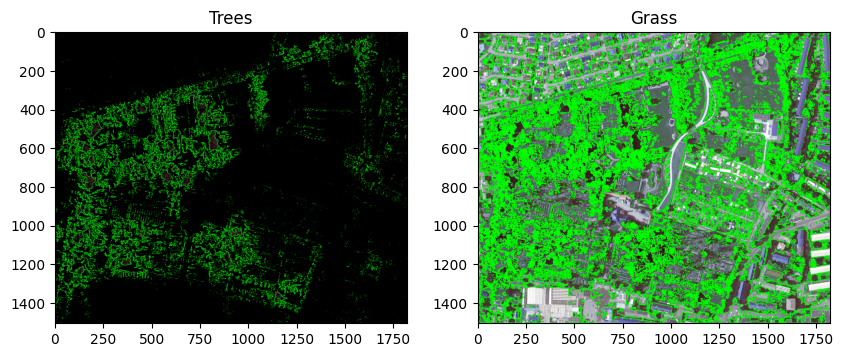

In [78]:
def apply_mask_to_image(image, mask):
    """
    Apply a binary mask to an image, making the masked area visible and the rest black.
    """
    masked_image = cv.bitwise_and(image, image, mask=mask)
    return masked_image

# Apply the masks to the original image
tree_masked_image = apply_mask_to_image(image_contours, mask)
grass_masked_image = apply_mask_to_image(image_contours, grass_mask)

# Now let's display the results
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(tree_masked_image)
plt.title('Trees')

plt.subplot(1, 2, 2)
plt.imshow(grass_masked_image)
plt.title('Grass')

plt.show()